In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/preprocess'
data_path = f'/content/{root_path}/DATA/'
model_path = f'/content/{root_path}/models/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# Import libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import spacy
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from wordcloud import WordCloud
EN = spacy.load('en_core_web_sm')

In [5]:
data = pd.read_csv(f'{data_path}Preprocessed_data.csv')
print(data.shape)
data.head()

(3574, 9)


,original_title,post_corpus,question_content,question_url,tags,overall_scores,sentiment_polarity,sentiment_subjectivity,processed_title
0,How difficult is computer networking,difficult computer networking student computer...,difficult computer networking student computer...,https://www.careervillage.org/questions/200717...,computer|information-technology|computer-netwo...,0,-0.218333,0.399762,difficult computer networking
1,How would I go about becoming a welder,would go becoming welder like hands stuff acti...,would go becoming welder like hands stuff acti...,https://www.careervillage.org/questions/200389...,welding|welder,2,-0.028231,0.390816,would go becoming welder
2,How hard is it to complete the years of school...,hard complete years school residency orthopedi...,hard complete years school residency orthopedi...,https://www.careervillage.org/questions/200577...,surgeon|orthopedicsurgeon|orthopedic|medical|m...,2,0.079545,0.549242,hard complete years school residency orthopedi...
3,Should I take physics or AP Bio senior year?,take physics ap bio senior year guidance couns...,take physics ap bio senior year guidance couns...,https://www.careervillage.org/questions/200525...,college|biology|physics|college-major|science|...,2,0.197667,0.464855,take physics ap bio senior year
4,What is the average salary of an actor?,average salary actor theatre acting actor non ...,average salary actor theatre acting actor,https://www.careervillage.org/questions/200445...,theatre|acting|actor,4,-0.025242,0.489881,average salary actor


In [6]:
data.post_corpus.iloc[0]

'difficult computer networking student computer nerd somewhat wondering difficult concepts within computer networking maybe confusing first take time patience learn computer information technology computer networking computer networking defines rules computer talk another computer distance computer nerd likes solve problems understands programming basics learning networking hard simple internet search learn computer networking reveal lot resources start already know concepts programming operating systems algorithms would suggest start computer programming learn algorithms data structures operating systems give base start learning computer networking somil recommends following next steps programming java shell script save algorithms data structures save operating system ubuntu save networking basics save'

In [0]:
data = data.dropna()

In [0]:
# Make a dict having tag frequencies
data.tags = data.tags.apply(lambda x: x.split('|'))
tag_freq_dict = {}
for tags in data.tags:
    for tag in tags:
        if tag not in tag_freq_dict:
            tag_freq_dict[tag] = 0
        else:
            tag_freq_dict[tag] += 1

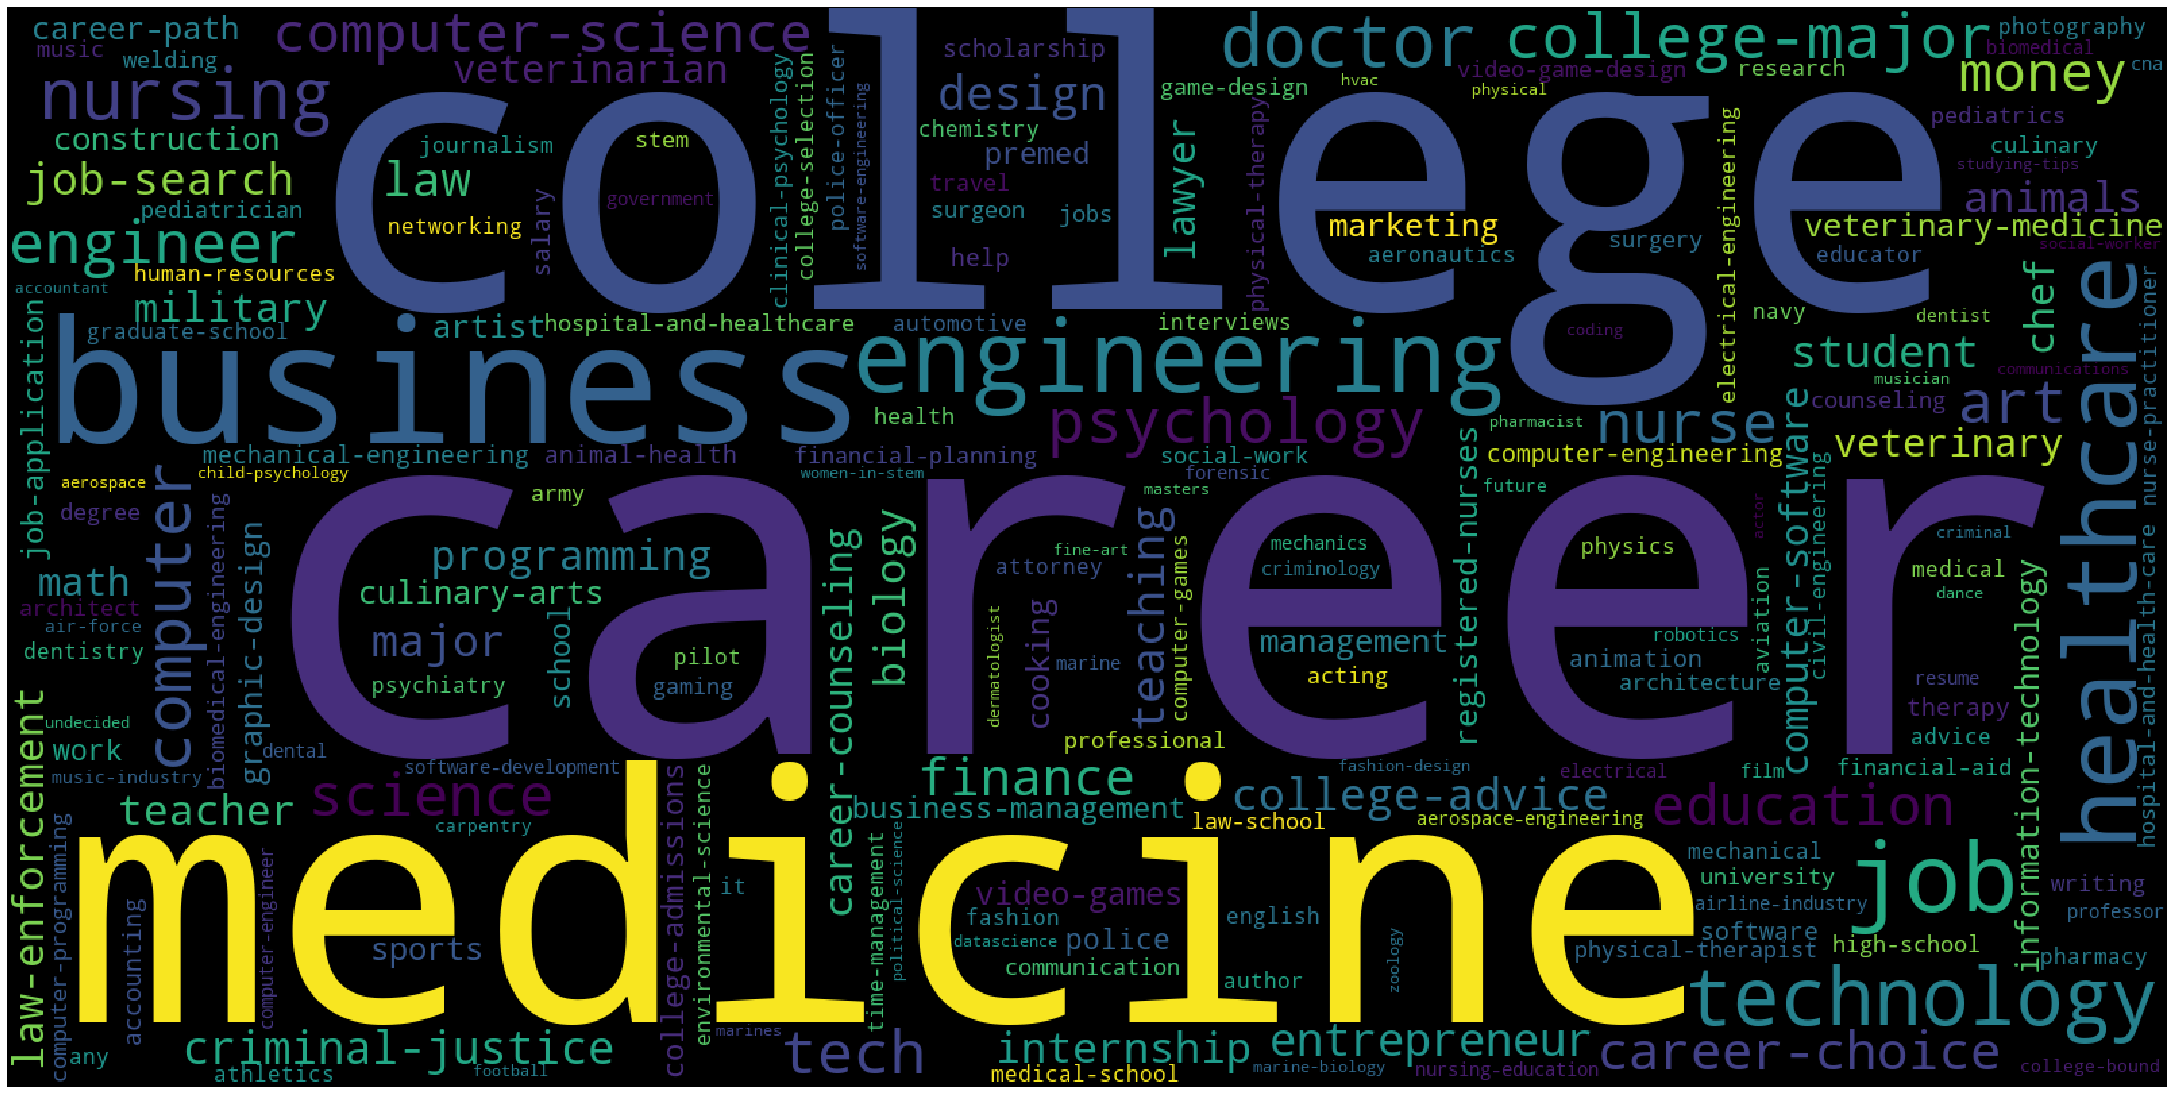

In [9]:
# Visualize all tags based on their frequencies using a WordCloud
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tag_freq_dict)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [10]:
tags_to_use = 1000
tag_freq_dict_sorted = dict(sorted(tag_freq_dict.items(), key=lambda x: x[1], reverse=True))
final_tags = list(tag_freq_dict_sorted.keys())[:tags_to_use]
len(final_tags)

1000

In [0]:
# Change tag data to only for final_tags
final_tag_data = []
for tags in data.tags:
    temp = []
    for tag in tags:
        if tag in final_tags:
            temp.append(tag)
    final_tag_data.append(temp)

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
tag_encoder = MultiLabelBinarizer()
tags_encoded = tag_encoder.fit_transform(final_tag_data)
tags_encoded.shape

(3572, 1000)

In [0]:
# Word2Vec
import gensim

# WORD2VEC 
W2V_SIZE = 30
W2V_WINDOW = 50
W2V_EPOCH = 15
W2V_MIN_COUNT = 10

# Collect corpus for training word embeddings
documents = [_text.split() for _text in np.array(data.post_corpus)]  # I used the entire corpus for training, because it contains the entire conversation of related to a user's posts

In [14]:
# Train Word Embeddings and save

w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)
w2v_model.build_vocab(documents)
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)
# Train Word Embeddings
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)
w2v_model.save(f'{model_path}SO_word2vec_embeddings.bin')


Vocab size 5186


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [15]:
w2v_model = gensim.models.word2vec.Word2Vec.load(f'{model_path}SO_word2vec_embeddings.bin')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [16]:
w2v_model.predict_output_word(['computer'])

[('computer', 0.98869854),
 ('software', 0.0057084616),
 ('hardware', 0.0038373913),
 ('computers', 0.00062713807),
 ('programmer', 0.0003751082),
 ('programming', 0.00033350056),
 ('science', 0.00018157756),
 ('laptop', 7.945613e-05),
 ('developer', 6.882659e-05),
 ('systems', 1.084137e-05)]

In [18]:
print('Terms most similar to "nursing"')
print(w2v_model.wv.most_similar("nursing"))
print('-'*100)

print('Terms most similar to "school"')
print(w2v_model.wv.most_similar("school"))
print('-'*100)

print('Terms most similar to "university"')
print(w2v_model.wv.most_similar("university"))
print('-'*100)

print('Terms most similar to "computer"')
print(w2v_model.wv.most_similar("computer"))
print('-'*100)


Terms most similar to "nursing"
[('nurse', 0.9317561984062195), ('nurses', 0.8096749782562256), ('rn', 0.8036958575248718), ('bsn', 0.7487561106681824), ('lpn', 0.7303803563117981), ('adn', 0.6983381509780884), ('midwifery', 0.6824315786361694), ('rns', 0.6767719984054565), ('care', 0.6616280674934387), ('icu', 0.6539812684059143)]
----------------------------------------------------------------------------------------------------
Terms most similar to "school"
[('grades', 0.726425051689148), ('college', 0.7188994884490967), ('attending', 0.6750456094741821), ('undergrad', 0.6550159454345703), ('academics', 0.6436256766319275), ('attend', 0.6420502662658691), ('grad', 0.6328741908073425), ('admissions', 0.6232687830924988), ('involvement', 0.6230986714363098), ('collegiate', 0.6209750175476074)]
----------------------------------------------------------------------------------------------------
Terms most similar to "university"
[('georgia', 0.806196928024292), ('uc', 0.723181128501892

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
data.head(2)

,original_title,post_corpus,question_content,question_url,tags,overall_scores,sentiment_polarity,sentiment_subjectivity,processed_title
0,How difficult is computer networking,difficult computer networking student computer...,difficult computer networking student computer...,https://www.careervillage.org/questions/200717...,"[computer, information-technology, computer-ne...",0,-0.218333,0.399762,difficult computer networking
1,How would I go about becoming a welder,would go becoming welder like hands stuff acti...,would go becoming welder like hands stuff acti...,https://www.careervillage.org/questions/200389...,"[welding, welder]",2,-0.028231,0.390816,would go becoming welder


In [0]:
# Split into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(data.processed_title), tags_encoded, test_size=0.2, random_state=42)
print("TRAIN size:", len(X_train))
print("TEST size:", len(X_test))

TRAIN size: 2857
TEST size: 715


In [0]:
# Tokenizing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.utils.np_utils import to_categorical

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 300


tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.post_corpus)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print('Found %s unique tokens.' % len(word_index))

# saving
import pickle
with open(f'{model_path}tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


Using TensorFlow backend.


Found 30056 unique tokens.


In [0]:
import pickle
with open(f'{model_path}/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print('Found %s unique tokens.' % len(word_index))

Found 30056 unique tokens.


In [0]:
# Convert the data to padded sequences
X_train_padded = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_padded, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train_padded.shape)

Shape of data tensor: (2857, 250)


In [0]:
X_train_padded

array([[   0,    0,    0, ...,    1, 1175,  428],
       [   0,    0,    0, ...,  997,   35,   21],
       [   0,    0,    0, ...,   50,  662,   21],
       ...,
       [   0,    0,    0, ..., 4402,  243,  830],
       [   0,    0,    0, ...,  479, 1798,   97],
       [   0,    0,    0, ...,  638, 1112, 1754]], dtype=int32)

In [0]:
# Embedding matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size+1, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(30057, 30)


In [0]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-2.78163552, -1.25797248,  0.97338295, ..., -4.90145636,
        -0.01391692, -0.64096695],
       [-2.20456719,  6.56738758,  2.20515227, ..., -1.1099683 ,
         1.25574005,  2.59969449],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [0]:
import keras.backend as K

# Custom loss function to handle multilabel classification task
def multitask_loss(y_true, y_pred):
    # Avoid divide by 0
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # Multi-task loss
    return K.mean(K.sum(- y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred), axis=1))

In [0]:

# Build Model
import keras 

model = Sequential()
model.add(Embedding(vocab_size+1, W2V_SIZE, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(LSTM(1000, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units = 10000,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )  
model.add(Dropout(0.35))
model.add(Dense(units = 1150,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )
model.add(Dropout(0.25))
model.add(Dense(units = 750,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )
model.add(Dense(1000, activation='sigmoid'))

model.summary()

model.compile(loss=multitask_loss,
              optimizer="adam")
              
# Train Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

BATCH_SIZE = 1024
history = model.fit(X_train_padded, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=30,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

# Save model
model.save(f'{model_path}Tag_predictor.h5')












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 30)           901710    
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000)              4124000   
_________________________________________________________________
dense_1 (Dense)              (None, 10000)             10010000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1150)              11501150  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1150)              0     

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2571/2571 [==============================] - 7s 3ms/step - loss: 95.4942 - val_loss: 42.8674
Epoch 3/30
2571/2571 [==============================] - 7s 3ms/step - loss: 43.4458 - val_loss: 40.6912
Epoch 4/30
2571/2571 [==============================] - 7s 3ms/step - loss: 40.9241 - val_loss: 37.2515
Epoch 5/30
2571/2571 [==============================] - 7s 3ms/step - loss: 36.6903 - val_loss: 34.7606
Epoch 6/30
2571/2571 [==============================] - 7s 3ms/step - loss: 33.4055 - val_loss: 31.8547
Epoch 7/30
2571/2571 [==============================] - 7s 3ms/step - loss: 30.3891 - val_loss: 29.1658
Epoch 8/30
2571/2571 [==============================] - 7s 3ms/step - loss: 27.3122 - val_loss: 25.0741
Epoch 9/30
2571/2571 [==============================] - 7s 3ms/step - loss: 23.6922 - val_loss: 22.2158
Epoch 10/30
2571/2571 [==============================] - 7s 3ms/step - loss: 21.1525 - val_loss: 21.1374
Epoch 11/30
2571/2571 [==============================] - 7s 3ms/step - los

In [0]:
# Helper function to save the training history for plotting purposes

import json,codecs
import numpy as np
def saveHist(path,history):

    new_hist = {}
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            new_hist[key] == history.history[key].tolist()
        elif type(history.history[key]) == list:
            if  type(history.history[key][0]) == np.float64:
                new_hist[key] = list(map(float, history.history[key]))

    print(new_hist)
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(new_hist, f, separators=(',', ':'), sort_keys=True, indent=4) 

def loadHist(path):
    with codecs.open(path, 'r', encoding='utf-8') as f:
        n = json.loads(f.read())
    return n

In [0]:
saveHist(f'{model_path}train_history.json',history)

{'val_loss': [158.88809204101562, 42.86739730834961, 40.69116973876953, 37.2514762878418, 34.76058578491211, 31.854738235473633, 29.165773391723633, 25.0740966796875, 22.215805053710938, 21.137407302856445, 20.577743530273438, 20.49608612060547, 20.481338500976562, 20.11505699157715, 20.14476203918457, 20.178281784057617, 19.83953857421875, 19.74356460571289, 19.776472091674805, 19.60260009765625, 19.55975341796875, 19.489839553833008, 19.415008544921875, 19.32896614074707, 19.279142379760742, 19.19102668762207, 19.101945877075195, 19.043363571166992, 19.029193878173828, 18.885343551635742], 'loss': [580.7564308288171, 95.49424138434524, 43.44580114476646, 40.92405207488195, 36.69026483649273, 33.405531057908995, 30.389133533491137, 27.312249378395748, 23.69218173522237, 21.152541343454534, 20.13424301815144, 19.736377658198567, 19.749092419571284, 19.68817785953743, 19.35232321755147, 19.30798673388653, 19.138038874878024, 18.986335756620143, 18.918874003923342, 18.79268172630212, 18.

In [0]:
from keras.models import load_model
import keras.losses

keras.losses.multitask_loss = multitask_loss
model1 = load_model(f'{model_path}Tag_predictor.h5')
history1 = loadHist(f'{model_path}train_history.json')

715/715 [==============================] - 1s 724us/step
LOSS: 17.71609879340325


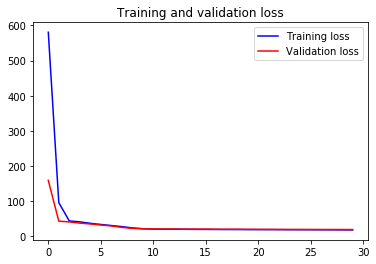

In [0]:
import matplotlib.pyplot as plt
X_test_padded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_padded, maxlen=MAX_SEQUENCE_LENGTH)
score = model.evaluate(X_test_padded, y_test, batch_size=512)
print("LOSS:",score)

loss = history1['loss']
val_loss = history1['val_loss']
 
epochs = range(len(loss))
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [0]:
def predict_tags(text):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LENGTH)
    # Predict
    prediction = model.predict([x_test])[0]
    for i,value in enumerate(prediction):
        if value > 0.5:
            prediction[i] = 1
        else:
            prediction[i] = 0
    tags = tag_encoder.inverse_transform(np.array([prediction]))
    return tags

In [0]:
test_idx = np.random.randint(len(X_test), size=5)

for idx in test_idx:
    test_case = idx
    print('Test Case: ' + str(X_test[test_case]))
    print('-'*100)
    print('Predicted: ' + str(predict_tags(X_test[test_case])))
    print('Ground Truth: ' + str(tag_encoder.inverse_transform(np.array([y_test[test_case]]))))
    print('\n')

Test Case: certain age start studying computer science
----------------------------------------------------------------------------------------------------
Predicted: [()]
Ground Truth: [('computer-science', 'tech', 'technology')]


Test Case: comp sci internships start
----------------------------------------------------------------------------------------------------
Predicted: [()]
Ground Truth: [('computer', 'computer-science', 'computer-software', 'engineer', 'internship', 'software', 'softwaredeveloper', 'softwareengineer', 'stem', 'technology', 'womeninstem')]


Test Case: advice help become marine biologist dream job going highschool next year need know build career
----------------------------------------------------------------------------------------------------
Predicted: [()]
Ground Truth: [('biology', 'career-counseling', 'job', 'marine-biology', 'technology')]


Test Case: much doctor make year
-----------------------------------------------------------------------------